In [2]:
!pip install pydicom
!pip install torch
!pip install torchio
!pip install segmentation-models-pytorch
!pip install timm

from google.colab import drive
drive.mount('/content/drive')


!git clone https://github.com/Tencent/MedicalNet.git
!wget https://huggingface.co/TencentMedicalNet/MedicalNet-Resnet18/resolve/main/resnet_18_23dataset.pth -O medicalnet_resnet18.pth
!mv /content/MedicalNet/* /content/
!mv /content/MedicalNet/.* /content/ 2>/dev/null  # hidden files

import sys
sys.path.append('/content/model.py')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'MedicalNet'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 120 (delta 50), reused 43 (delta 43), pack-reused 51 (from 1)
Receiving objects: 100% (120/120), 47.63 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (50/50), done.
--2025-05-14 01:05:21--  https://huggingface.co/TencentMedicalNet/MedicalNet-Resnet18/resolve/main/resnet_18_23dataset.pth
Resolving huggingface.co (huggingface.co)... 108.138.246.79, 108.138.246.85, 108.138.246.71, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.79|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/dd/8a/dd8a9ae97766ca85e4667dfdd45a93597f605bee19ada224de91e5f50eb47e0c/61224f9317fcce873366deb3703183e92cc47325b726b69691b33536244e10f4?res

In [3]:
import torch
import torch.nn as nn
import torchvision.models as tv_models
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_encoder

In [4]:
import os
import torch
import torch.nn as nn
from model import generate_model


# Define the config-style class used by MedicalNet's generate_model()
class MedicalNetOptions:
    def __init__(self, model_depth=18, input_D=16, input_H=112, input_W=122):
        self.model = 'resnet'
        self.model_depth = model_depth
        self.input_D = input_D
        self.input_H = input_H
        self.input_W = input_W
        self.resnet_shortcut = 'A'
        self.no_cuda = False
        self.n_seg_classes = 1
        self.gpu_id = [0]
        self.phase = 'train'
        self.pretrain_path = ''
        self.new_layer_names = []

# Main wrapper class to use MedicalNet's ResNet18
class MedicalNet3DResNet18(nn.Module):
    def __init__(self, output_dim=10, pretrained_path=None):
        """
        :param output_dim: Number of regression outputs (5 or 10)
        :param pretrained_path: Path to downloaded MedicalNet .pth weights
        :param freeze_until: Freeze N blocks (0 = none, 4 = all)
        """
        super(MedicalNet3DResNet18, self).__init__()

        # Create MedicalNet-style options object
        opt = MedicalNetOptions()

        # Generate base model
        self.backbone, *_ = generate_model(opt)
        def forward_patch(self_inner, x):
            x = self_inner.conv1(x)
            x = self_inner.bn1(x)
            x = self_inner.relu(x)
            x = self_inner.maxpool(x)
            x = self_inner.layer1(x)
            x = self_inner.layer2(x)
            x = self_inner.layer3(x)
            x = self_inner.layer4(x)
            return x

        self.backbone.module.forward = forward_patch.__get__(self.backbone.module, type(self.backbone.module))



        # Load pretrained weights if path is given
        if pretrained_path and os.path.exists(pretrained_path):
            checkpoint = torch.load(pretrained_path, map_location='cpu')
            state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
            new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
            self.backbone.load_state_dict(new_state_dict, strict=False)

        self.output_head = nn.Sequential(
             nn.AdaptiveAvgPool3d(1),  # Global average pooling
             nn.Flatten(),
             nn.Linear(512, output_dim),  # 512 is final channel count in ResNet18
             nn.Sigmoid()
         )

    def forward(self, x):
        x = self.backbone(x)  # Output: (B, 512, 1, 1, 1) or similar
        #print(f"Backbone output shape: {x.shape}")
        x = self.output_head(x)
        return x


In [5]:
# --- SMP-based U-Net with Multi-head Regression (no CBAM) ---
class SMP_UNet_MIT(nn.Module):
    def __init__(self, n_heads=5):
        super(SMP_UNet_MIT, self).__init__()
        self.mode = '0'
        self.n_heads = n_heads

        # Load encoder and decoder from full Unet using timm-mit_b3
        self.unet = smp.Unet(
            encoder_name="mit_b0",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1  # dummy output
        )

        self.encoder = self.unet.encoder
        self.decoder = self.unet.decoder


        self.shared_conv = nn.Conv2d(16, 64, kernel_size=1)

        self.heads = nn.ModuleDict({
            str(i): nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 2)
            ) for i in range(1, n_heads + 1)
        })

    def setmode(self, mode):
        self.mode = str(mode)

    def forward(self, x):
        features = self.encoder(x)
        d = self.decoder(features)
        shared = self.shared_conv(d)
        return self.heads[self.mode](shared)


In [ ]:

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(out)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x


class CBAMConvNeXt(nn.Module):
    def __init__(self, num_classes=3):
        super(CBAMConvNeXt, self).__init__()
        # Load ConvNeXt Base model
        self.model = tv_models.convnext_base(pretrained=True)

        # Extract features
        self.features = self.model.features

        # Add CBAM after the final feature extraction stage
        self.cbam = CBAM(in_planes=1024)  # ConvNeXt Base final feature size

        # Modify Classifier
        num_ftrs = self.model.classifier[2].in_features
        self.model.classifier = nn.Sequential(
            nn.LayerNorm(num_ftrs),
            nn.Flatten(),
            nn.Dropout(0.4),  # Dropout for regularization
            nn.Linear(num_ftrs, num_classes)
        )



    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.cbam(x)      # CBAM attention module
        x = x.mean([2, 3])    # Global Average Pooling
        x = self.model.classifier(x)  # Classifier
        return x

class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomDenseNet121, self).__init__()
        # Load DenseNet121 with pretrained ImageNet weights
        self.model = tv_models.densenet121(pretrained=True)


        # Modify the classifier part of DenseNet
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)
        

    def forward(self, x):
        return self.model(x)


class CustomConvNeXt(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomConvNeXt, self).__init__()

        #  Load ConvNeXt Base Model (Pretrained)
        self.model = tv_models.convnext_base(pretrained=True)

        #  Modify Classifier
        num_ftrs = self.model.classifier[2].in_features
        self.model.classifier[2] = nn.Linear(num_ftrs, num_classes)
       

    def forward(self, x):
        return self.model(x)



In [68]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Neural Foraminal Narrowing (Sagittal T1): 10 labels
model_sagittal_t1 = MedicalNet3DResNet18(
    output_dim=10,
    pretrained_path=None,
).to(device)
model_sagittal_t1.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/resnet_models/Sagittal_T1.pth', map_location=device))

# Subarticular Stenosis (Axial T2): 10 labels
model_axial_t2 = MedicalNet3DResNet18(
    output_dim=10,
    pretrained_path=None,
).to(device)
model_axial_t2.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/resnet_models/Axial_T2.pth', map_location=device))

# Spinal Canal Stenosis (Sagittal T2/STIR): 5 labels
model_sagittal_t2stir = MedicalNet3DResNet18(
    output_dim=5,
    pretrained_path=None,
).to(device)
model_sagittal_t2stir.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/resnet_models/Sagittal_T2_STIR.pth', map_location=device))

# ====== Store in dictionaries ======
models = {
    'Sagittal T1': model_sagittal_t1,
    'Axial T2': model_axial_t2,
    'Sagittal T2/STIR': model_sagittal_t2stir,
}


sagittal_t2stir_model = SMP_UNet_MIT().to(device)
sagittal_t2stir_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/UNet_models/Sagittal_T2_STIR.pth', map_location=device))
sagittal_t1left_model = SMP_UNet_MIT().to(device)
sagittal_t1left_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/UNet_models/Sagittal_T1_Left.pth', map_location=device))
sagittal_t1right_model = SMP_UNet_MIT().to(device)
sagittal_t1right_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/UNet_models/Sagittal_T1_Right.pth', map_location=device))
axial_t2left_model = SMP_UNet_MIT().to(device)
axial_t2left_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/UNet_models/Axial_T2_Left.pth', map_location=device))
axial_t2right_model = SMP_UNet_MIT().to(device)
axial_t2right_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/UNet_models/Axial_T2_Right.pth', map_location=device))


# Store the models and optimizers in dictionaries for easy access
models_cp = {
    'Sagittal T1 Left': sagittal_t1left_model,
    'Sagittal T1 Right': sagittal_t1right_model,
    'Axial T2 Left': axial_t2left_model,
    'Axial T2 Right': axial_t2right_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}



#sagittal_t1_model = CustomConvNeXt(num_classes=3).to(device)
#sagittal_t1_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/convnextbase_models/Sagittal_T1.pth', map_location=device))
#axial_t2_model = CustomConvNeXt(num_classes=3).to(device)
#axial_t2_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/convnextbase_models/Axial_T2.pth', map_location=device))
#sagittal_t2stir_model = CustomConvNeXt(num_classes=3).to(device)
#sagittal_t2stir_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/convnextbase_models/Sagittal_T2_STIR.pth', map_location=device))


sagittal_t1_model = CustomDenseNet121(num_classes=3).to(device)
sagittal_t1_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/densenet121_models/Sagittal_T1.pth', map_location=device))
axial_t2_model = CustomDenseNet121(num_classes=3).to(device)
axial_t2_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/densenet121_models/Axial_T2.pth', map_location=device))
sagittal_t2stir_model = CustomDenseNet121(num_classes=3).to(device)
sagittal_t2stir_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/densenet121_models/Sagittal_T2_STIR.pth', map_location=device))


#sagittal_t1_model = CBAMConvNeXt(num_classes=3).to(device)
#sagittal_t1_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/convnextcbam_models/Sagittal_T1.pth', map_location=device))
#axial_t2_model = CBAMConvNeXt(num_classes=3).to(device)
#axial_t2_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/convnextcbam_models/Axial_T2.pth', map_location=device))
#sagittal_t2stir_model = CBAMConvNeXt(num_classes=3).to(device)
#sagittal_t2stir_model.load_state_dict(torch.load('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/convnextcbam_models/Sagittal_T2_STIR.pth', map_location=device))

models_sv = {
    'Sagittal T1': sagittal_t1_model,
    'Axial T2': axial_t2_model,
    'Sagittal T2/STIR': sagittal_t2stir_model,
}

/content/models/resnet.py:173: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00,

In [113]:
# Inference pipeline for all 3 views
import torch
import numpy as np
import cv2
import pydicom
from PIL import Image
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchio as tio
import matplotlib.pyplot as plt

def get_3d_transform_pipeline():
    transforms = [
        tio.Resample((1.5, 1.5, 3.0)),
        tio.CropOrPad((16, 112, 112)),
        tio.ZNormalization(),
        tio.Clamp(out_min=-5, out_max=5),
    ]
    return tio.Compose(transforms)

def load_dicom_volume_sorted(folder_path):
    slice_info = []
    for fname in os.listdir(folder_path):
        if fname.endswith('.dcm'):
            full_path = os.path.join(folder_path, fname)
            dcm = pydicom.dcmread(full_path)
            instance_number = getattr(dcm, 'InstanceNumber', 0)
            slice_info.append((instance_number, dcm.pixel_array.astype(np.float32)))
    slice_info.sort(key=lambda x: x[0])
    sorted_imgs = [img for _, img in slice_info]
    volume_original = np.stack(sorted_imgs, axis=0)
    volume_original = volume_original / np.max(volume_original) if np.max(volume_original) > 0 else volume_original
    volume_resized = np.stack([cv2.resize(img, (112, 112)) for img in sorted_imgs], axis=0)
    volume_resized = volume_resized / np.max(volume_resized) if np.max(volume_resized) > 0 else volume_resized
    return volume_resized, volume_original

def preprocess_instance_volume(volume):
    volume = np.expand_dims(volume, axis=0)
    subject = tio.Subject(img=tio.ScalarImage(tensor=torch.tensor(volume)))
    volume = get_3d_transform_pipeline()(subject).img.data
    return volume

def denormalize_and_window(preds, total_depth, window):
    preds = torch.round(preds * total_depth).int().tolist()
    windowed = [list(range(max(0, p - window), min(total_depth, p + window + 1))) for p in preds]
    return windowed

def coordinate_inference(instances, model, regression_head, level):
    model.setmode(str(regression_head))
    transform = A.Compose([
        A.Resize(640, 640),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    coords = []
    for idx, img in enumerate(instances):
        img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        processed = transform(image=img_rgb)['image'].unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(processed).squeeze().cpu().numpy()
        coords.append(pred)
    return coords

def crop_image(img, x, y, condition):
    a = 20
    crop_params = {
        "Spinal Canal Stenosis": (96+a, 32+a, 40+a, 40+a),
        "Left Neural Foraminal Narrowing": (96+4*a, 64-3*a, 32+a, 32+a),
        "Right Neural Foraminal Narrowing": (96+4*a, 64-3*a, 32+a, 32+a),
        "Left Subarticular Stenosis": (48+3*a, 144+3*a, 96+5*a, 96-3*a),
        "Right Subarticular Stenosis": (144+a, 48+a, 96+5*a, 96-3*a),
    }
    if condition == 'Sagittal T2/STIR':
        condition = "Spinal Canal Stenosis"
    l, r, u, d = crop_params[condition]
    h, w = img.shape
    x, y = int(x), int(y)
    left = max(0, x - l)
    right = min(w, x + r)
    top = max(0, y - u)
    bottom = min(h, y + d)
    cropped = img[top:bottom, left:right]
    return cropped

def predict_severity(cropped_img_windows, model, temperature=5.0):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    final_preds = []
    for window_imgs in cropped_img_windows:
        all_probs = []
        for img in window_imgs:
            img_tensor = transform(Image.fromarray(img)).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = model(img_tensor)
                logits += torch.randn_like(logits) * 0.3
                scaled_logits = logits / temperature
                probs = torch.softmax(scaled_logits, dim=1).squeeze()
                all_probs.append(probs.cpu().numpy())
        all_probs = np.array(all_probs)
        best_idx = int(np.argmax(np.max(all_probs, axis=1)))
        final_class = int(np.argmax(all_probs[best_idx]))
        final_preds.append((best_idx, final_class))
    return final_preds

def run_inference(volume_path, view_name):
    models[view_name].eval()
    if view_name == 'Sagittal T2/STIR':
        models_cp[view_name].eval()
        models_sv[view_name].eval()
    else:
        models_cp[f"{view_name} Left"].eval()
        models_cp[f"{view_name} Right"].eval()
        models_sv[view_name].eval()

    with torch.no_grad():
        volume_112, volume_original = load_dicom_volume_sorted(volume_path)
        depth = len(volume_original)
        preprocessed = preprocess_instance_volume(volume_112)
        pred = models[view_name](preprocessed.unsqueeze(0).to(device)).squeeze(0)

        def display_row(inst_coords_preds, condition, split_labels=False):
            label_map = ['Moderate', 'Normal/Mild', 'Severe']
            if split_labels:
                fig, axes = plt.subplots(2, 5, figsize=(20, 5))
                for idx, (inst, coords, pred) in enumerate(inst_coords_preds):
                    ax = axes[idx // 5, idx % 5]
                    label = label_map[pred] if 0 <= pred < 3 else f"Invalid({pred})"
                    crop = crop_image(volume_original[inst], *coords, condition)
                    title_prefix = 'Left' if idx < 5 else 'Right'
                    ax.imshow(crop, cmap='gray')
                    ax.set_title(f"{title_prefix}\nInst {inst}\n{label}")
                    ax.axis('off')
                plt.tight_layout()
                plt.show()
            else:
                plt.figure(figsize=(20, 5))
                for i, (inst, coords, pred) in enumerate(inst_coords_preds):
                    label = label_map[pred] if 0 <= pred < 3 else f"Invalid({pred})"
                    crop = crop_image(volume_original[inst], *coords, condition)
                    plt.subplot(1, len(inst_coords_preds), i + 1)
                    plt.imshow(crop, cmap='gray')
                    plt.title(f"Inst {inst}\n{label}")
                    plt.axis('off')
                plt.tight_layout()
                plt.show()

        if view_name == 'Sagittal T2/STIR':
            windows = denormalize_and_window(pred, depth, window=1)
            model_cp = models_cp[view_name]
            model_sv = models_sv[view_name]
            results = []
            outputs_to_display = []
            for i, inst_nums in enumerate(windows):
                slices = [volume_original[n] for n in inst_nums]
                coords = coordinate_inference(slices, model_cp, i + 1, i)
                cropped = [crop_image(volume_original[n], *coords[j], view_name) for j, n in enumerate(inst_nums)]
                severity_output = predict_severity([cropped], model_sv)[0]
                idx, sev = severity_output
                outputs_to_display.append((inst_nums[idx], coords[idx], sev))
                results.append(sev)
            display_row(outputs_to_display, view_name)
            return results

        elif view_name == 'Sagittal T1' or view_name == 'Axial T2':
            left_windows = denormalize_and_window(pred[:5], depth, window=2 if view_name == 'Sagittal T1' else 1)
            right_windows = denormalize_and_window(pred[5:], depth, window=2 if view_name == 'Sagittal T1' else 1)
            view_prefix = 'Left' if view_name == 'Sagittal T1' else 'Left Subarticular Stenosis'
            view_suffix = 'Right' if view_name == 'Sagittal T1' else 'Right Subarticular Stenosis'
            results = []
            outputs_to_display = []
            for side, windows, prefix in zip(["Left", "Right"], [left_windows, right_windows], [view_prefix, view_suffix]):
                model_cp = models_cp[f"{view_name} {side}"]
                model_sv = models_sv[view_name]
                for i, inst_nums in enumerate(windows):
                    slices = [volume_original[n] for n in inst_nums]
                    coords = coordinate_inference(slices, model_cp, i + 1, i)
                    condition = f"{prefix} Neural Foraminal Narrowing" if "T1" in view_name else prefix
                    cropped = [crop_image(volume_original[n], *coords[j], condition) for j, n in enumerate(inst_nums)]
                    severity_output = predict_severity([cropped], model_sv)[0]
                    idx, sev = severity_output
                    outputs_to_display.append((inst_nums[idx], coords[idx], sev))
                    results.append(sev)
            display_row(outputs_to_display, condition, split_labels=True)
            return results


Running Inference for Sagittal T2/STIR view


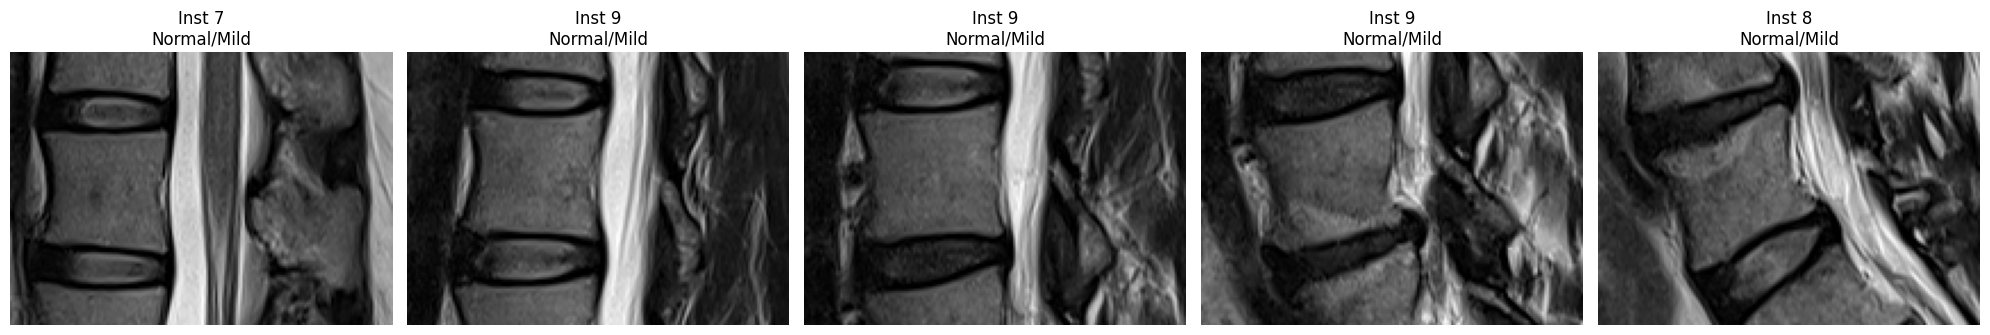

Running Inference for Axial T2 view


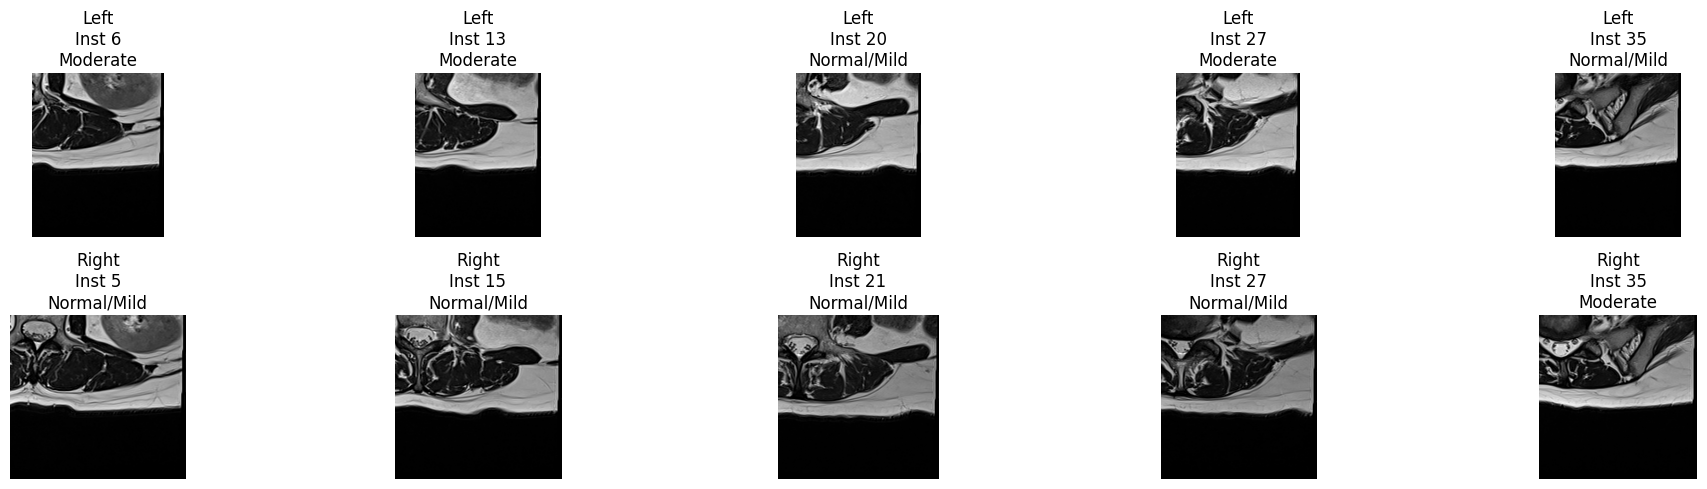

Running Inference for Sagittal T1 view


<ipython-input-113-6e055870e3bb>:135: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.imshow(crop, cmap='gray')


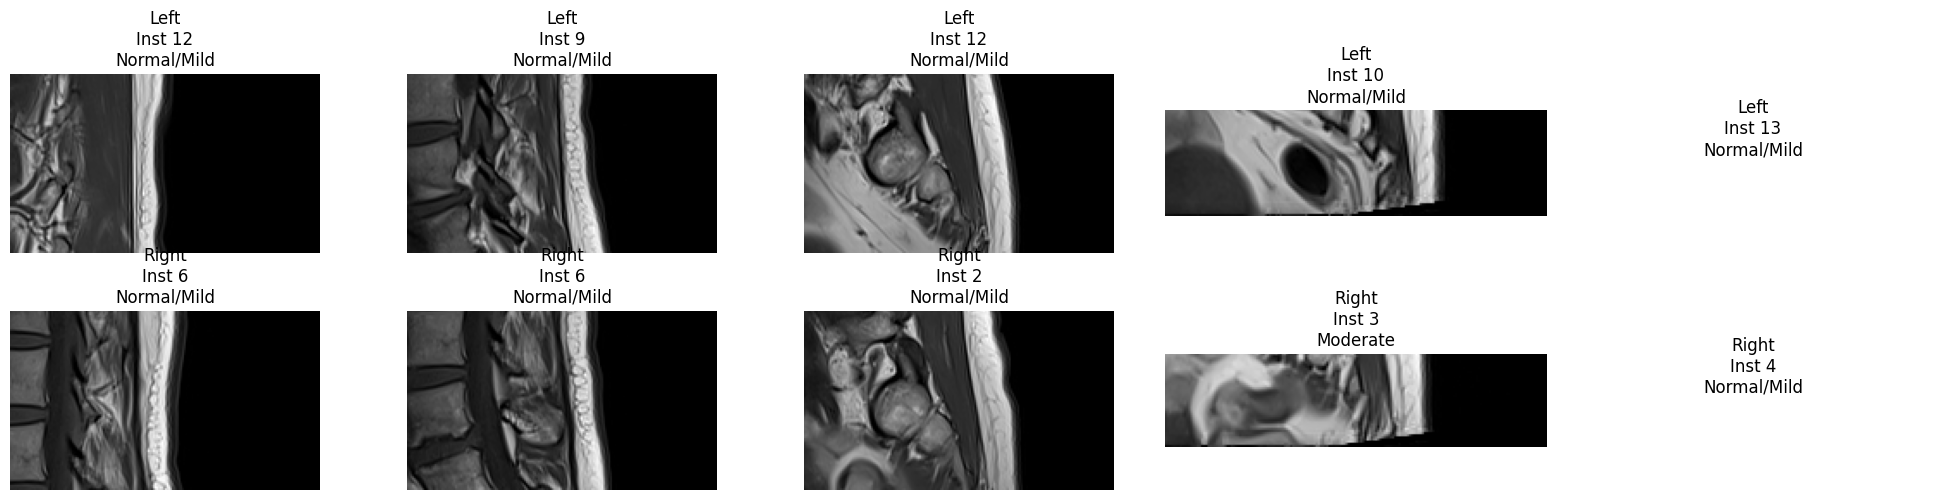

In [114]:

# Example call for Sagittal T2/STIR
print("Running Inference for Sagittal T2/STIR view")
predictions_t2stir = run_inference(
    view_name="Sagittal T2/STIR",
    volume_path="/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833"
)
#import sys
#sys.exit("Stopping cell execution.")
# Example call for Axial T2 (Subarticular Stenosis - left/right)
print("Running Inference for Axial T2 view")
predictions_t2 = run_inference(
    view_name="Axial T2",
    volume_path="/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/2448190387"
)

# Example call for Sagittal T1 (Neural Foraminal Narrowing - left/right)
print("Running Inference for Sagittal T1 view")
predictions_t1 = run_inference(
    view_name="Sagittal T1",
    volume_path="/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/1054713880"
)
